In [110]:
%matplotlib widget

import sys, glob, yaml
sys.path.append('../toolbox/')
sys.path.append('../weld')
from lambda_calc import *
from multi_robot import *
from dx200_motion_program_exec_client import *
from WeldSend import *
from RobotRaconteur.Client import *
from weldRRSensor import *
from motoman_def import *
from flir_toolbox import *
import weld_dh2v
import matplotlib.pyplot as plt

from datetime import datetime
import re
import numpy_indexed as npi

def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy
    
def avg_by_line(job_line, flame_pos):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.zeros((len(average_pos), 4))
    output[:,0] = job_line_unique
    output[:,1:] = average_pos
    return output
          


x=0
layer =  50


dataset='bent_tube/'
sliced_alg='slice_ER_4043_dense/'
data_dir='../data/'+dataset+sliced_alg

def flame_detection_aluminum(raw_img,threshold=1.0e4,area_threshold=4,percentage_threshold=0.8):
    ###flame detection by raw counts thresholding and connected components labeling
    #centroids: x,y
    #bbox: x,y,w,h
    ###adaptively increase the threshold to 60% of the maximum pixel value
    threshold=max(threshold,percentage_threshold*np.max(raw_img))
    thresholded_img=(raw_img>threshold).astype(np.uint8)

    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_img, connectivity=4)
    
    valid_indices=np.where(stats[:, cv2.CC_STAT_AREA] > area_threshold)[0][1:]  ###threshold connected area
    if len(valid_indices)==0:
        return None, None, None, None
    
    average_pixel_values = [np.mean(raw_img[labels == label]) for label in valid_indices]   ###sorting
    valid_index=valid_indices[np.argmax(average_pixel_values)]      ###get the area with largest average brightness value

    # Extract the centroid and bounding box of the largest component
    centroid = centroids[valid_index]
    bbox = stats[valid_index, :-1]

    return centroid, bbox

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']
print(angle)


save_path = f'../../recorded_data/ER4043_bent_tube_2024_07_18_13_37_40/layer_{layer}/'
with open(save_path+'ir_recording.pickle', 'rb') as file:
        ir_recording = pickle.load(file)



H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')
print(H)

0.11257976619508031
[[-2.46887427e-01 -9.69044167e-01  0.00000000e+00  8.85847192e-16]
 [ 9.69044167e-01 -2.46887427e-01  0.00000000e+00  3.72339150e-16]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


0
749


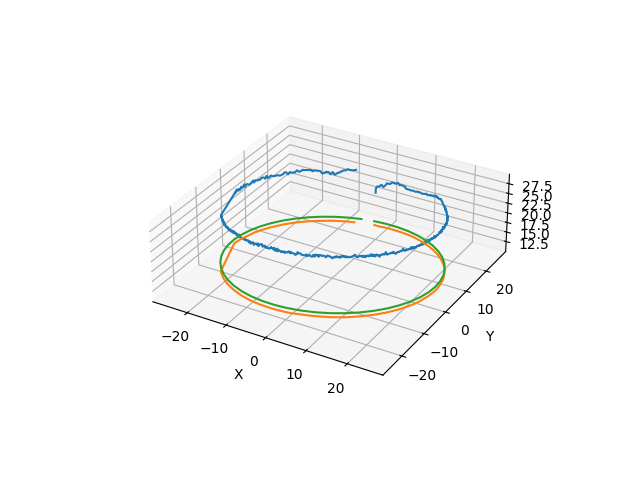

In [111]:
flame_3d=[]
job_no = []
torch_path = []
ir_ts=np.loadtxt(save_path+'ir_stamps.csv', delimiter=',')
curve_sliced_relative=np.loadtxt(data_dir+'curve_sliced_relative/slice'+str(layer)+'_0.csv',delimiter=',')
curve_sliced_relative = curve_sliced_relative[:,0:3]
if len(ir_ts)>0:
    joint_angle=np.loadtxt(save_path+'weld_js_exe.csv', delimiter=',')

    timeslot=[ir_ts[0]-ir_ts[0], ir_ts[-1]-ir_ts[0]]
    duration=np.mean(np.diff(timeslot))


    for start_time in timeslot[:-1]:
        
        start_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time))
        end_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time-duration))
        print(start_idx)
        print(end_idx)

        #find all pixel regions to record from flame detection
        for i in range(start_idx,end_idx):
            
            ir_image = ir_recording[i]
            try:
                centroid, bbox=flame_detection_aluminum(ir_image, percentage_threshold=0.8)
            except ValueError:
                centroid = None
            if centroid is not None:
                #find spatial vector ray from camera sensor
                vector=np.array([(centroid[0]-flir_intrinsic['c0'])/flir_intrinsic['fsx'],(centroid[1]-flir_intrinsic['r0'])/flir_intrinsic['fsy'],1])
                vector=vector/np.linalg.norm(vector)
                #find index closest in time of joint_angle
                joint_idx=np.argmin(np.abs(ir_ts[i]-joint_angle[:,0]))
                robot2_pose_world=robot2.fwd(joint_angle[joint_idx][8:-2],world=True)
                p2=robot2_pose_world.p
                v2=robot2_pose_world.R@vector
                robot1_pose=robot.fwd(joint_angle[joint_idx][2:8])
                p1=robot1_pose.p
                v1=robot1_pose.R[:,2]
                positioner_pose=positioner.fwd(joint_angle[joint_idx][-2:], world=True)

                #find intersection point
                intersection=line_intersect(p1,v1,p2,v2)
                # Convert to positioner frame
                
                intersection = positioner_pose.R.T@(intersection-positioner_pose.p)
                torch = positioner_pose.R.T@(robot1_pose.p-positioner_pose.p)

                torch_path.append(torch)
                flame_3d.append(intersection)
                job_no.append(int(joint_angle[joint_idx][1]))
flame_3d = np.array(flame_3d)
torch_path = np.array(torch_path)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.plot3D(torch_path[:,0], torch_path[:,1], torch_path[:,2])
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
plt.show()


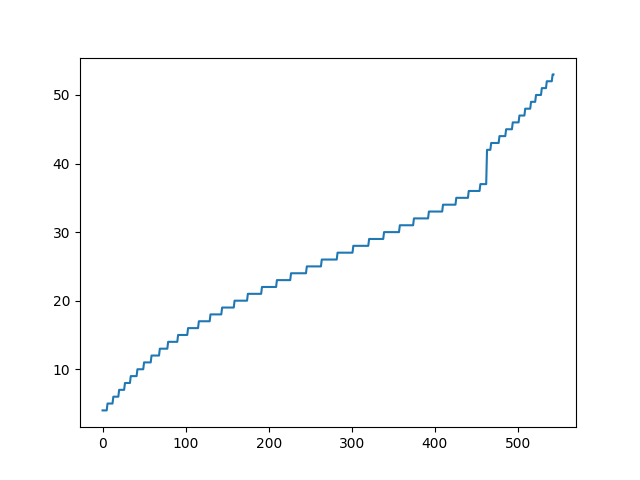

Min Job no:  4
Max Job no:  53
Job Len:  544
Flame len:  544


In [112]:
fig,ax = plt.subplots()
ax.plot(job_no)
plt.show()
print("Min Job no: ", job_no[0])
print("Max Job no: ", job_no[-1])
print("Job Len: ", len(job_no))
print("Flame len: ", len(flame_3d))

[[-0.24688743  0.96904417  0.        ]
 [-0.96904417 -0.24688743 -0.        ]
 [ 0.          0.          1.        ]]
[[-0.24688743  0.96904417 -0.        ]
 [-0.96904417 -0.24688743 -0.        ]
 [ 0.          0.          1.        ]]


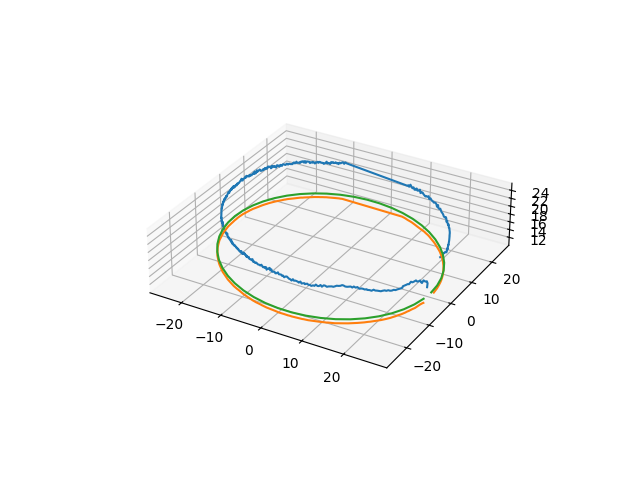

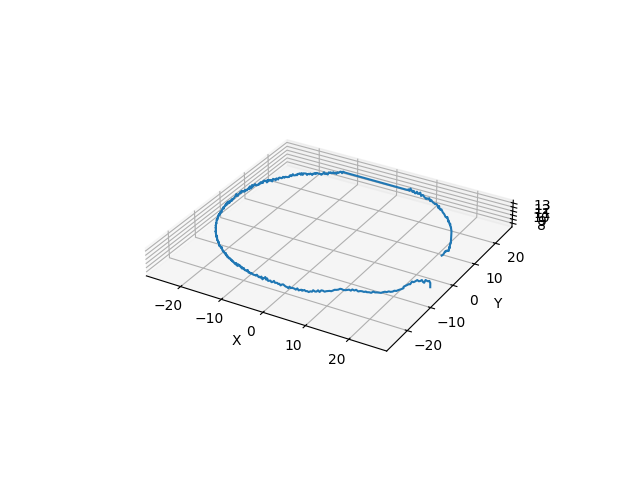

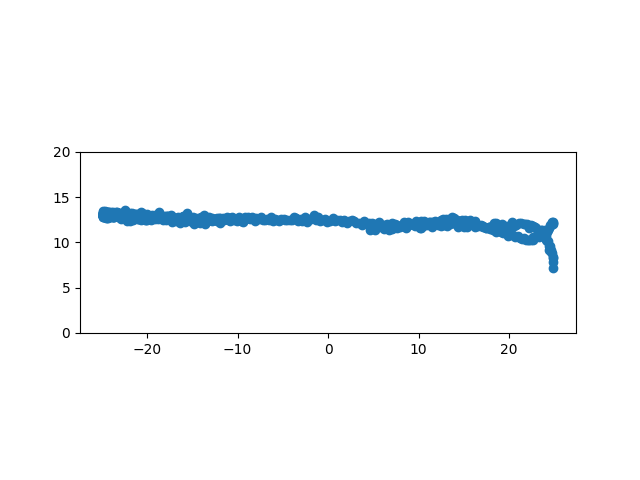

In [113]:
p = H[:3, -1]
R = H[:3, :3]
R_inv = np.linalg.inv(R)
print(R_inv)
print(R.T)
torch_path[:, -1] = torch_path[:,-1]
flame_3d[:, -1] = flame_3d[:, -1]-4
#convert back to designed part frame
for i in range(flame_3d.shape[0]):
    torch_path[i] = R.T@torch_path[i]
    flame_3d[i] = R.T@flame_3d[i]
for i in range(curve_sliced_relative.shape[0]):
    curve_sliced_relative[i] = R_inv@curve_sliced_relative[i]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.plot3D(torch_path[:,0], torch_path[:,1], torch_path[:,2])
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_aspect('equal')
plt.show()
layer_angle = angle*(layer-1)
layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,0), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.set_aspect('equal')

ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig,ax = plt.subplots()
ax.scatter(flame_3d[:,0], flame_3d[:, -1])
ax.set_ylim(0,20)
ax.set_aspect('equal')
plt.show()

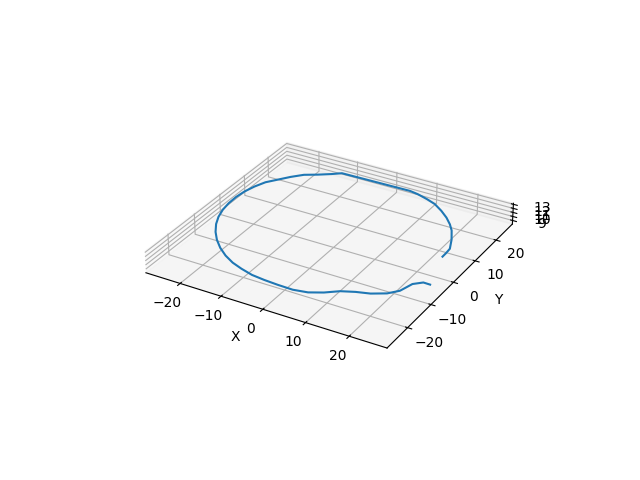

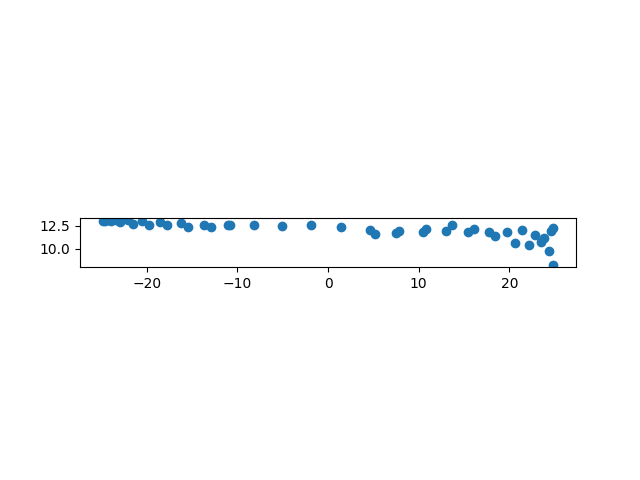

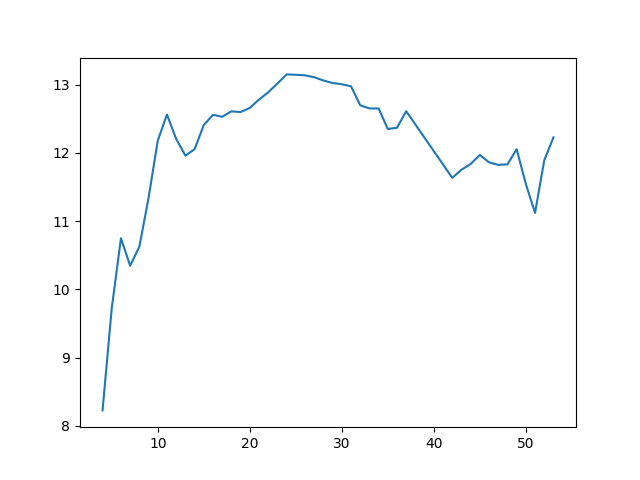

In [114]:
averages = avg_by_line(job_no, flame_3d)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(averages[:,1], averages[:,2], averages[:,3])
ax.set_aspect('equal')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig,ax = plt.subplots()
ax.scatter(averages[:,1], averages[:, -1])
ax.set_aspect('equal')
plt.show()

# height_plot
fig,ax = plt.subplots()
ax.plot(averages[:,0], averages[:,-1])
plt.show()

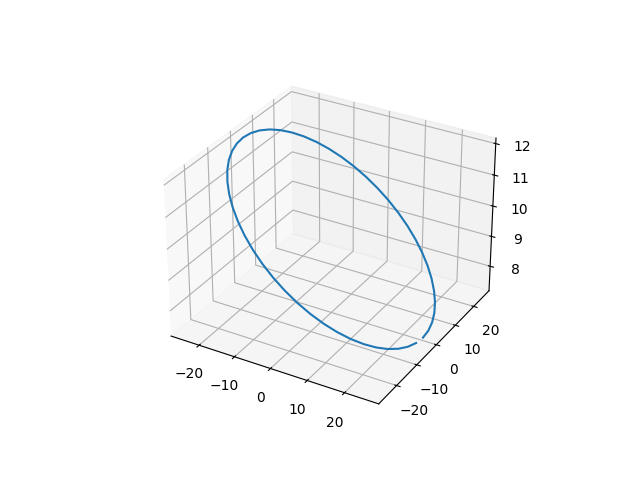

100.6131657840027
5.516408543558935
[ 25.          24.80286753  24.21457903  23.24441215  21.907667
  20.22542486  18.22421569  15.93559974  13.39566987  10.64448229
   7.72542486   4.68453286   1.56976299  -1.56976299  -4.68453286
  -7.72542486 -10.64448229 -13.39566987 -15.93559974 -18.22421569
 -20.22542486 -21.907667   -23.24441215 -24.21457903 -24.80286753
 -25.         -24.80286753 -24.21457903 -23.24441215 -21.907667
 -20.22542486 -18.22421569 -15.93559974 -13.39566987 -10.64448229
  -7.72542486  -4.68453286  -1.56976299   1.56976299   4.68453286
   7.72542486  10.64448229  13.39566987  15.93559974  18.22421569
  20.22542486  21.907667    23.24441215  24.21457903  24.80286753]
[-5.32907052e-15 -1.77635684e-15  7.10542736e-15 -8.88178420e-16
  8.88178420e-16  1.33226763e-14 -4.44089210e-15  1.77635684e-15
  1.77635684e-15 -1.77635684e-15  1.77635684e-15  5.32907052e-15
  1.77635684e-15  3.55271368e-15 -1.06581410e-14  0.00000000e+00
 -8.88178420e-15  1.77635684e-15 -7.10542736e-1

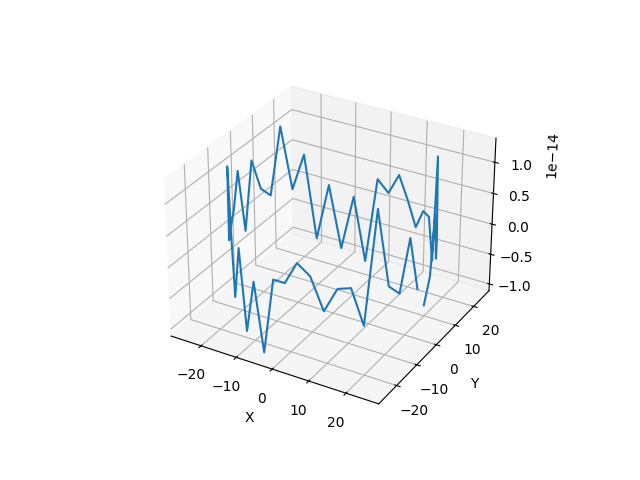

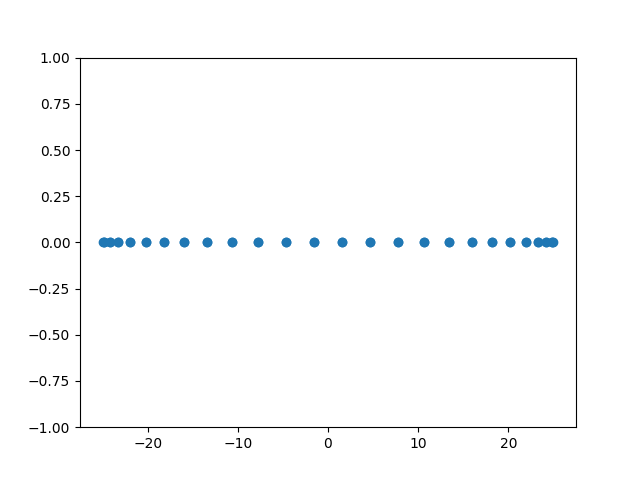

In [115]:
curve_sliced_relative=np.loadtxt(data_dir+'curve_sliced_relative/slice'+str(layer)+'_0.csv',delimiter=',')
curve_sliced_relative = curve_sliced_relative[:,0:3]


p = H[:3, -1]
R = H[:3, :3]
R_inv = np.linalg.inv(R)
curve_sliced_relative[:, -1] = curve_sliced_relative[:, -1]-4
#convert back to designed part frame
for i in range(curve_sliced_relative.shape[0]):
    curve_sliced_relative[i] = R_inv@curve_sliced_relative[i]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
plt.show()
print(por)
layer_angle = angle*(layer-1)
print(layer_angle)
layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,0), (curve_sliced_relative[:,0], curve_sliced_relative[:,2]), layer_angle)
print(new_x)
print(new_z)
curve_sliced_relative[:,0] = new_x
curve_sliced_relative[:,2] = new_z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig, ax = plt.subplots()
ax.scatter(curve_sliced_relative[:,0], curve_sliced_relative[:, -1])
ax.set_ylim(-1,1)
plt.show()